In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# numericalization
from collections import Counter

# preprocessing
from string import punctuation
import re

# modeling
from sklearn.model_selection import train_test_split


# neural nets
import tensorflow as tf
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import Sequential, Input, optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

pd.set_option('display.max_columns', 500)
title_fontsize = 15

In [7]:
sent_df = pd.read_csv('./data/balanced_tokenized_cleaned_stocktwits.csv', 
                 parse_dates=['created_at']).drop('body', axis=1)

stocks_df = pd.read_csv('./data/scraped_stock_2015_2022.csv', 
                        parse_dates=['Date']).iloc[:, 1:]

In [8]:
# find all indexes with tickers
df = sent_df['raw_content'].str.upper().str.extractall(r'\$(\w+)')[0].reset_index()

# remove indexes containing more than one ticker
df = sent_df.drop(df[df['match'] == 1]['level_0'].tolist())

# add ticker 
df['ticker'] = df['raw_content'].str.upper().str.extract(r'\$(\w+)')

# extract date only
df['Date'] = df['created_at'].dt.date

# get average sentiment per day
df = df.groupby(['ticker', 'Date']).agg({'sentiment': 'mean'}).reset_index()
df['Date'] = pd.to_datetime(df['Date'])

df['ticker'].unique()

array(['AAPL', 'AAPLLOOKS', 'AAPLSTAY', 'AMZN', 'AMZNGET', 'FB', 'FB1',
       'FBZUK', 'NVDA', 'TSLA'], dtype=object)

In [9]:
def clean_tickers(ticker):
    if 'AAPL' in ticker:
        ticker = 'AAPL'
    elif 'AMZN' in ticker:
        ticker = 'AMZN'
    elif 'FB' in ticker:
        ticker = 'META'
    else:
        ticker = ticker
        
    return ticker

df['ticker'] = df['ticker'].apply(lambda x: clean_tickers(x))

In [10]:
for tick in df['ticker'].unique():
    df1 = df[df['ticker'] == tick]
    df2 = stocks_df[stocks_df['Stock Name'] == tick]
    
    globals()[tick] = pd.merge(df1, df2, on='Date').iloc[:, 1:]
    
    
    
#test
AAPL

,Date,sentiment,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2019-12-31,0.428571,72.482498,73.419998,72.379997,73.412498,71.920578,100805600,AAPL
1,2020-01-02,0.563452,74.059998,75.150002,73.797501,75.087502,73.561539,135480400,AAPL
2,2020-01-03,0.357143,74.287498,75.144997,74.125000,74.357498,72.846375,146322800,AAPL
3,2020-01-06,0.433333,73.447502,74.989998,73.187500,74.949997,73.426819,118387200,AAPL
4,2020-01-07,0.409091,74.959999,75.224998,74.370003,74.597504,73.081497,108872000,AAPL
...,...,...,...,...,...,...,...,...,...
541,2022-02-18,0.215054,169.820007,170.539993,166.190002,167.300003,166.546555,82772700,AAPL
542,2022-02-22,0.526316,164.979996,166.690002,162.149994,164.320007,163.579987,91162800,AAPL
543,2022-02-23,0.378049,165.539993,166.149994,159.750000,160.070007,159.349121,90009200,AAPL
544,2022-02-24,0.443548,152.580002,162.850006,152.000000,162.740005,162.007095,141147500,AAPL


<AxesSubplot: ylabel='High'>

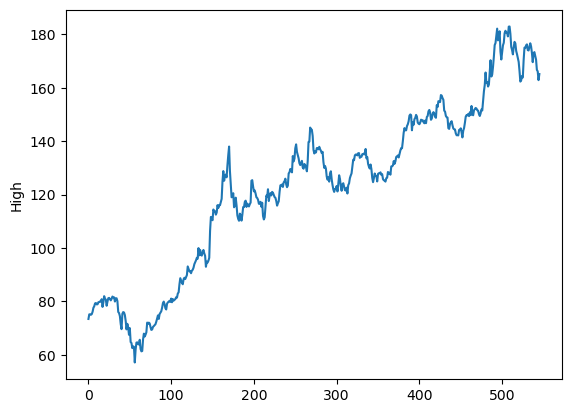

In [15]:
import plotly.express as px

In [27]:
stocks_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name'],
      dtype='object')

In [31]:
stocks_df.Date.dt.year.max()

2022

In [26]:
stocks_df[stocks_df.Date.dt.year.between(2015, 2022)]

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,TSLA
1,2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,TSLA
2,2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,TSLA
3,2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,TSLA
4,2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,TSLA
...,...,...,...,...,...,...,...,...
45435,2022-09-22,13.730000,14.600000,13.400000,13.740000,13.740000,23489400,XPEV
45436,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
45437,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
45438,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV


In [34]:
stocks_df[stocks_df['Stock Name'] == 'AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
13643,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.603210,212818400,AAPL
13644,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.910091,257142000,AAPL
13645,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.912342,263188400,AAPL
13646,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.247650,160423600,AAPL
13647,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.179293,237458000,AAPL
...,...,...,...,...,...,...,...,...
15587,2022-09-22,152.380005,154.470001,150.910004,152.740005,152.487045,86652500,AAPL
15588,2022-09-23,151.190002,151.470001,148.559998,150.429993,150.180862,96029900,AAPL
15589,2022-09-26,149.660004,153.770004,149.639999,150.770004,150.520309,93339400,AAPL
15590,2022-09-27,152.740005,154.720001,149.949997,151.759995,151.508667,84442700,AAPL


In [41]:
fig_data.Date.dt.year

13643    2015
13644    2015
13645    2015
13646    2015
13647    2015
         ... 
15587    2022
15588    2022
15589    2022
15590    2022
15591    2022
Name: Date, Length: 1949, dtype: int64

In [55]:
go.Line(x='Date', y='High')

/Users/setone/miniforge3/envs/tf-gpu/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




{'x': 'Date', 'y': 'High'}

In [80]:
import plotly.graph_objects as go

company = 'AAPL'

fig_data = stocks_df[stocks_df['Stock Name'] == company]

fig = px.line(
        fig_data,
        x='Date',
        y='High',
        # name = 'Original Price',
        title = f'{company} Stock',
        template=template_from_url(theme),
    )

fig30 = fig_data['High'].rolling(window=30).mean()
fig50 = fig_data['High'].rolling(window=50).mean()
# maybe add a for loop here?
fig.add_trace(go.Scatter(x=fig_data['Date'], y=fig30, name='30 day MA'))
fig.add_trace(go.Scatter(x=fig_data['Date'], y=fig50, name='50 day MA'))

fig.show()

IndentationError: unexpected indent (544649720.py, line 16)

In [74]:
fig30 = stocks_df[stocks_df['Stock Name'] == company]['High'].rolling(window=30).mean()

<AxesSubplot: ylabel='High'>

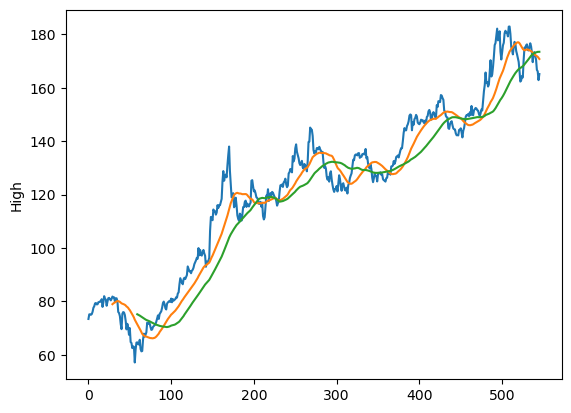

In [14]:
sns.lineplot(data=AAPL, x=AAPL.index, y='High')
AAPL['High'].rolling(window=30).mean().plot()
AAPL['High'].rolling(window=60).mean().plot()
# AAPL['sentiment'].rolling(window=30).mean().plot()

<AxesSubplot:>

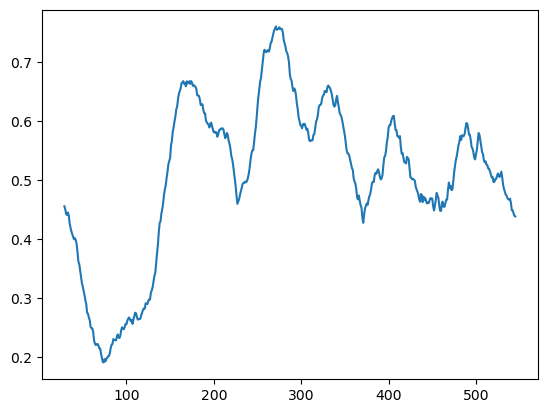

In [8]:
AAPL['sentiment'].rolling(window=30).mean().plot()

<AxesSubplot:>

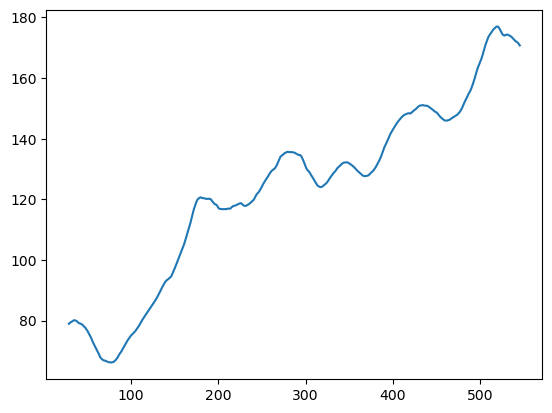

In [189]:
AAPL['High'].rolling(window=30).mean().plot()
# AAPL['sentiment'].rolling(window=30).mean().plot()

Text(0.5, 1.0, 'AAPL')

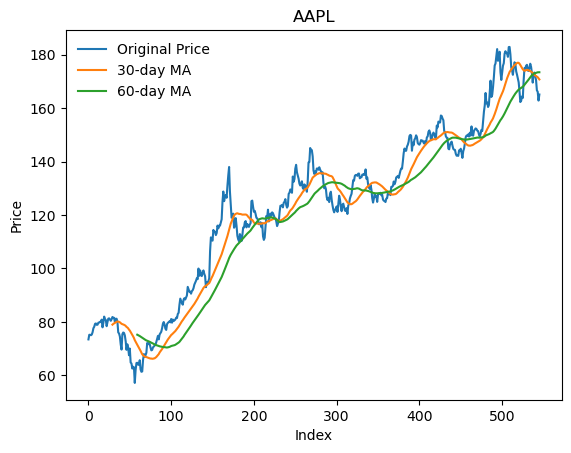

In [25]:
plt.plot(AAPL['High'], label='Original Price')
plt.plot(AAPL['High'].rolling(window=30).mean(), label='30-day MA')
plt.plot(AAPL['High'].rolling(window=60).mean(), label='60-day MA')
plt.legend(frameon=False)
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('AAPL')

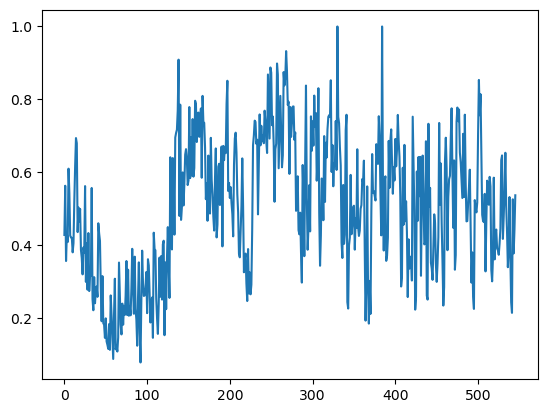

In [28]:
plt.plot(AAPL['sentiment'])

In [29]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates(pred_type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {pred_type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {pred_type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [30]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model